In [3]:
!pip install qiskit==0.37.0  # or a specific version that supports Aer
!pip install qiskit-aer==0.10.4
!pip install qiskit-optimization==0.4.0

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import QAOA
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.7/929.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.0 MB/s eta 0:00:00
  Created

The following cell implements a solver for the Maximum Independent Set (MIS) problem based on the paper "A Quantum Approximate Optimization Algorithm" by Farhi et al. The paper presents approximate algorithms for solving optimization problems involving quadratic functions. In this implementation, we design a QUBO (Quadratic Unconstrained Binary Optimization) matrix. In this matrix, selecting individual vertices does not incur a positive cost, but edges in the graph are encoded with positive costs. This encoding discourages the selection of adjacent vertices in the graph, ensuring that the algorithm favors independent sets where no two selected vertices are directly connected.

For the paper "A Quantum Approximate Optimization Algorithm", please refer to the following: https://arxiv.org/abs/1411.4028


In [4]:
# Define the QUBO matrix for the graph

# for example consider a c4(four cycle with one of the chords connected, we should be able to pick the two non-connected cords)


# QUBO matrix for the c4 + (0,2) chord added
qubo_matrix = {
    (0, 0): -1,
    (1, 1): -1,
    (2, 2): -1,
    (3, 3): -1,
    (0, 1): 2,
    (1, 2): 2,
    (2, 3): 2,
    (3, 0): 2,
    (0, 2): 2,
}

# Initialize the Quadratic Program
qp = QuadraticProgram()

# Add variables to the quadratic program
num_variables = max(max(i, j) for i, j in qubo_matrix.keys()) + 1
for i in range(num_variables):
    qp.binary_var(name=f"x{i}")

# Set the objective function
qp.minimize(quadratic=qubo_matrix)

# Convert the QuadraticProgram to QUBO
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp)

# Quantum Instance and QAOA
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=4096)
qaoa = QAOA(quantum_instance=quantum_instance, reps=3)
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# MIS solve
result = qaoa_optimizer.solve(qubo)
print("Optimal value:", result.fval)
print("Solution:", result.x)

Optimal value: -2.0
Solution: [0. 1. 0. 1.]


Here we will implement how characteristic graph is built for D0LI problem.


Recall the definition we proposed for the characteristic graph of a D0LI problem which was the following:\\
- For $0 \leq i \leq m-1$ and $1 \leq j \leq |w_i|$, we construct complete graphs $G_{i,j}$ such that:
  $$
  V(G_{i,j}) = \{(i,j,\text{start},\text{end}) : j \leq \text{start} \leq \text{end} \leq |w_{i+1}|-|w_i|+j\}.
  $$

- We then define $V(G_{\rho}) = \bigcup\limits_{0\leq i<m,1\leq j\leq |w_{i}|} V(G_{ij}).$

Hereafter, we will define $E(G_{\rho})$. Let $v,w\in V(G_{\rho})$; $v\in V(G_{i_1,j_1})$ and $w\in V(G_{i_2,j_2})$, therefore, $v=(i_1,j_1,s_1,e_1)$ and $w=(i_2,j_2,s_2,e_2)$, then $(v,w) \in E(G_{\rho})$ if at least one of the following conditions hold:

1. $w_{i_1}[j_1]=w_{i_2}[j_2]$ and $w_{i_1+1}[s_1:e_1] \neq w_{i_2+1}[s_2:e_2]$.
2. $i_1=i_2$, $j_1+1 = j_2$ and $e_1\neq s_2-1$.


In [5]:
def char_graph_dl(seq):
    vertex_set = dict()

    m = len(seq) - 1

    for i in range(m):
        lag = len(seq[i + 1]) - len(seq[i])
        for j in range(len(seq[i])):
            if j == 0 and j == len(seq[i]) - 1:
                start = 0
                end = len(seq[i + 1]) - 1
                vertex_set[(i, j, start, end)] = {}
            elif j == 0:
                start = 0
                for end in range(0, lag + 1):
                    vertex_set[(i, j, start, end)] = {}
            elif j == len(seq[i]) - 1:
                end = len(seq[i + 1]) - 1
                for start in range(j, end + 1):
                    vertex_set[(i, j, start, end)] = {}
            else:
                for start in range(j, lag + j + 1):
                    for end in range(start, lag + j + 1):
                        vertex_set[(i, j, start, end)] = {}


    for node_1 in list(vertex_set.keys()):
        i_1 , j_1 , start_1 , end_1 = node_1

        for node_2 in list(vertex_set.keys()):

            i_2 , j_2 , start_2 , end_2 = node_2

            if node_1 in vertex_set[node_2].keys() or node_1 == node_2:
                continue
            elif seq[i_1][j_1] == seq[i_2][j_2]:
                vertex_set[node_1][node_2] = 1
                vertex_set[node_2][node_1] = 1
            elif i_1 == i_2 and j_1 == j_2+1 or j_2 == j_1+1:
                vertex_set[node_1][node_2] = 1
                vertex_set[node_2][node_1] = 1
    return vertex_set

# simple case to see how the connections are made
seq = ['AA', 'ABA']
vertex_set = char_graph_dl(seq)

# checking connections
for a in vertex_set:
    for b in vertex_set[a]:
        print(a,b,"were connected")



(0, 0, 0, 0) (0, 0, 0, 1) were connected
(0, 0, 0, 0) (0, 1, 1, 2) were connected
(0, 0, 0, 0) (0, 1, 2, 2) were connected
(0, 0, 0, 1) (0, 0, 0, 0) were connected
(0, 0, 0, 1) (0, 1, 1, 2) were connected
(0, 0, 0, 1) (0, 1, 2, 2) were connected
(0, 1, 1, 2) (0, 0, 0, 0) were connected
(0, 1, 1, 2) (0, 0, 0, 1) were connected
(0, 1, 1, 2) (0, 1, 2, 2) were connected
(0, 1, 2, 2) (0, 0, 0, 0) were connected
(0, 1, 2, 2) (0, 0, 0, 1) were connected
(0, 1, 2, 2) (0, 1, 1, 2) were connected


In the following cell we build some intuition on how the characteristic graph is looks like.

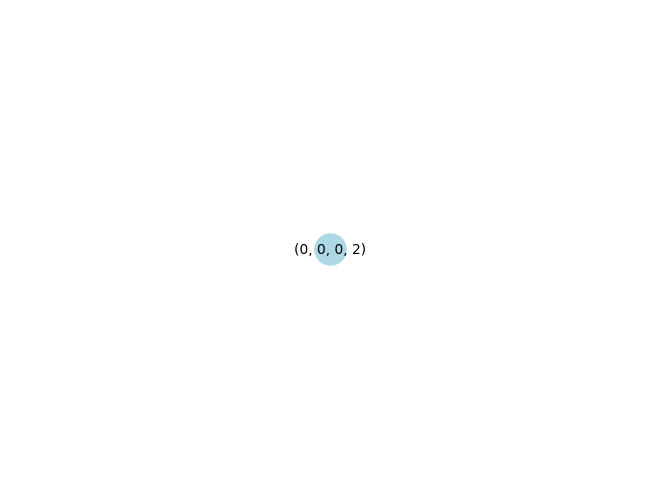

In [6]:
def plot_vertex_graph(vertex_set):
    """
    Takes a vertex set dictionary where keys are node labels and values are lists of connected nodes.
    Constructs and plots the corresponding graph.

    Parameters:
    vertex_set (dict): A dictionary where each key is a node and its value is a list of nodes it connects to.
    """
    G = nx.Graph()

    # Add nodes and edges from vertex_set
    for node_1, connections in vertex_set.items():
        G.add_node(node_1)
        for node_2 in connections:
            G.add_edge(node_1, node_2)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.show()

seq = seq = ['A', 'ABA']
vertex_set = char_graph_dl(seq)
plot_vertex_graph(vertex_set)

In the code cell after, we are testing our main result which is Theorem 5.1 and also the algorithm afterwards.

The Theorem wasa as following:

Assume $V = \{v_1, \ldots, v_n\}$ is a language, and $\rho = (w_0, \ldots, w_n)$ is a sequence over $V$, then there exists an L-system $G$ that produces $\rho$ if and only if $G_{\rho}$ has a maximum independent set of size $k$, where:
	\[
	k = \sum_{i=0}^{m-1}\lvert w_i \rvert.
	\]


Furhtermore, our algorithm was the following: **Algorithm: Solves D0LI or D0L-Inference**

**Procedure**: `QunatInferD0L(w_0, w_1, \dots, w_m)`

1. $V \gets \{w_{i}[j] \mid 0 \leq i < m , 1 \leq j \leq |w_{i}|\}$
2. $\omega \gets w_0$
3. $P \gets \{\}$
4. $\rho \gets (w_0, w_1, \dots, w_m)$
5. Construct $G_{\rho}$
6. $I \gets Quant_{MSI}(G_{\rho})$
7. $k \gets \sum_{i=0}^{n-1}\lvert w_i \rvert$
8. **if** $|I|<k$ **then**
   - return `False`
9. **for** $(i,j,s,e) \in I$ **do**
   - Add $w_i[j]\rightarrow w_{i+1}[s:e]$ to $P$
10. **return** $(V, \omega, P)$


In [7]:


def is_independent_set(G, nodes):
    """Check if the set of nodes is an independent set."""
    for u, v in combinations(nodes, 2):
        if G.has_edge(u, v):
            return False
    return True

def has_independent_set_of_exact_size_K(G, K):
    """Check if the graph G has an independent set of exactly size K."""
    # Only check sets of size K
    for subset in combinations(G.nodes, K):
        if is_independent_set(G, subset):
            return subset
    return None

def d0l_inference_solver(seq):
    # Original data structure and process
    K = sum(len(a) for a in seq[:-1])

    vertex_set = dict()

    m = len(seq) - 1

    for i in range(m):
        lag = len(seq[i + 1]) - len(seq[i])
        for j in range(len(seq[i])):
            if j == 0 and j == len(seq[i]) - 1:
                start = 0
                end = len(seq[i + 1]) - 1
                vertex_set[(i, j, start, end)] = {}
            elif j == 0:
                start = 0
                for end in range(0, lag + 1):
                    vertex_set[(i, j, start, end)] = {}
            elif j == len(seq[i]) - 1:
                end = len(seq[i + 1]) - 1
                for start in range(j, end + 1):
                    vertex_set[(i, j, start, end)] = {}
            else:
                for start in range(j, lag + j + 1):
                    for end in range(start, lag + j + 1):
                        vertex_set[(i, j, start, end)] = {}

    for node_1 in list(vertex_set.keys()):
        i_1, j_1, start_1, end_1 = node_1
        for node_2 in list(vertex_set.keys()):
            i_2, j_2, start_2, end_2 = node_2
            if node_1 in vertex_set[node_2].keys() or node_1 == node_2:
                continue
            elif seq[i_1][j_1] == seq[i_2][j_2] and seq[i_1 + 1][start_1: end_1 + 1] != seq[i_2 + 1][start_2: end_2 + 1]:
                vertex_set[node_1][node_2] = 1
                vertex_set[node_2][node_1] = 1
            elif i_1 == i_2 and j_2 == j_1 + 1 and end_1 != start_2 - 1:
                vertex_set[node_1][node_2] = 1
                vertex_set[node_2][node_1] = 1

    # plot_vertex_graph(vertex_set)

    # Creating the NetworkX graph from vertex_set

    G = nx.Graph()
    for node_1, connections in vertex_set.items():
        G.add_node(node_1)
        for node_2 in connections:
            G.add_edge(node_1, node_2)

    # Check for an independent set of exact size K
    independent_set = has_independent_set_of_exact_size_K(G, K)

    if independent_set is None:
        print("No solution to the D0L inference problem exists for the sequence:", seq)
        return False

    productions = {(seq[i][j], seq[i+1][start:end+1]) for (i, j, start, end) in independent_set}
    return productions

seq = ['AB', 'ABAB', 'ABABABAB']
print(d0l_inference_solver(seq))

seq = ['X', 'X+YF+']
print(d0l_inference_solver(seq))

{('B', 'BAB'), ('A', 'A')}
{('X', 'X+YF+')}


In [8]:
# here we will test s sequence which should not have a solution


seq = ['AA', 'ABAC', 'ABABABAB']
print(d0l_inference_solver(seq))

No solution to the D0L inference problem exists for the sequence: ['AA', 'ABAC', 'ABABABAB']
False


In [15]:

seq = ['X', 'X+YF+', 'X+YF++-F-YF+']
print(d0l_inference_solver(seq))

{('Y', '-'), ('F', 'F-YF'), ('+', '+'), ('X', 'X+YF+')}


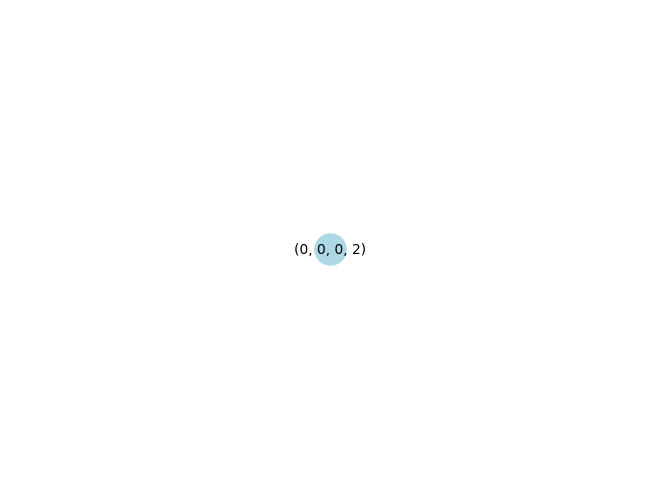

In [13]:
seq = seq = ['A', 'ABA']
vertex_set = char_graph_dl(seq)
plot_vertex_graph(vertex_set)